# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [99]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


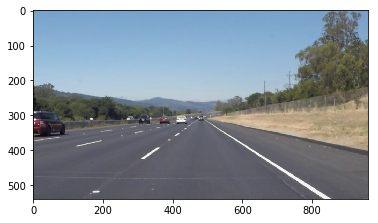

In [100]:
# Reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [101]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def mean_of_list_values(list):
     return (sum(list)) / max(len(list), 1)

def draw_lines(img, lines, color=[255, 0, 0], thickness = 10):
    # Defining the lists so I can average all of the values lanes
    leftLane_list = []
    rightLane_list = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # If the slope is negative then it is the left lane else if it is positive it is a right lane list
            # "...To decide which segments are part of the left line vs. the right line"
            slope = ((y2-y1)/(x2-x1))
            if slope < 0:
                leftLane_list.append( slope )
            else:
                rightLane_list.append( slope )
                
    # Getting the mean of the all of the values for the left and right lanes
    # "Then, you can average the position of each of the lines"
    averageLeftLane = mean_of_list_values(leftLane_list)
    averageRightLane = mean_of_list_values(rightLane_list)
    
    # Extrapolate the slopes from the top to bottom end points of the late
    # "...Extrapolate to the top and bottom of the lane"
    max_y_Value = image.shape[0]
    min_y_Value = 400
    
    x1 = min_y_Value/averageLeftLane
    y1 = max_y_Value/averageLeftLane
    
    x2 = max_y_Value/averageLeftLane
    y2 = min_y_Value/averageLeftLane
    
    cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness) 

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [102]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

The shape of solid white curve image is --> (540, 960, 3)
The shape of solid white right image is --> (540, 960, 3)
The shape of solid yellow curve image is --> (540, 960, 3)
The shape of solid yellow curve 2 image is --> (540, 960, 3)
The shape of solid yellow left image is --> (540, 960, 3)
The shape of white car lane switch image is --> (540, 960, 3)


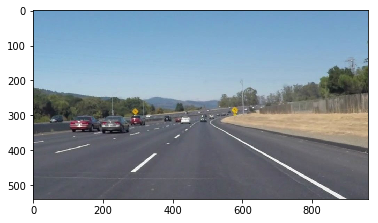

In [103]:
# Uncommented each line to see if I can display each image

solidWhiteCurve = mpimg.imread('test_images/solidWhiteCurve.jpg')
print("The shape of solid white curve image is -->", image.shape)

#solidWhiteRight = mpimg.imread('test_images/solidWhiteRight.jpg')
print("The shape of solid white right image is -->", image.shape)

#solidYellowCurve = mpimg.imread('test_images/solidYellowCurve.jpg')
print("The shape of solid yellow curve image is -->", image.shape)

#solidYellowCurve2 = mpimg.imread('test_images/solidYellowCurve2.jpg')
print("The shape of solid yellow curve 2 image is -->", image.shape)

#solidYellowLeft = mpimg.imread('test_images/solidYellowLeft.jpg')
print("The shape of solid yellow left image is -->", image.shape)

#whiteCarLaneSwitch = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
print("The shape of white car lane switch image is -->", image.shape)

plt.imshow(solidWhiteCurve)
#plt.imshow(solidWhiteRight)
#plt.imshow(solidYellowCurve)
#plt.imshow(solidYellowCurve2)
#plt.imshow(solidYellowLeft)
#plt.imshow(whiteCarLaneSwitch)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [104]:
def process_image_pipeline(image):
    
    # Grayscale: Converts image to gray scale (used helper function provided)
    grayscale_img = grayscale(image)

    # Gaussian: Applies a gaussian noise kernal to the image (used helper function provided)
    gaussian_blur_img = gaussian_blur(grayscale_img, 5)

    # Canny: Sets up a canny transform
    canny_img = canny(gaussian_blur_img, 50, 130)
        
    # Size: Getting image size/shape
    y_size = image.shape[0]
    x_size = image.shape[1]

    # Region of interest: I defined a region of interest here (used helper function provided)
    vertices = np.array([[(50, y_size), (450, 320), (500, 320), (x_size, y_size)]], dtype = np.int32)
    region_of_interest_img = region_of_interest(canny_img, vertices)

    # Hough Lines: Sets up the parameters of the hough lines
    hough_lines_img = hough_lines(region_of_interest_img, 1 , np.pi/180, 20, 10, 200)

    # Weighted Image: Sets up the image to be processed
    weighted_image = weighted_img(hough_lines_img, image)
    plt.imshow(weighted_image)
    
    return weighted_image

## Naming Images

In [106]:
# Processing all of the images in the folder -> "Build the pipeline and run your solution on all test_images"
all_test_images = os.listdir("test_images/")
print("The names of all of the following images below are: ", "\n")
print(all_test_images[0], "\n")
print(all_test_images[1], "\n")
print(all_test_images[2], "\n")
print(all_test_images[3], "\n")
print(all_test_images[4], "\n")
print(all_test_images[5], "\n")

The names of all of the following images below are:  

solidWhiteCurve.jpg 

whiteCarLaneSwitch.jpg 

solidWhiteRight.jpg 

solidYellowCurve.jpg 

solidYellowCurve2.jpg 

solidYellowLeft.jpg 



## Processing images

solidWhiteCurve.jpg is currently being processed!


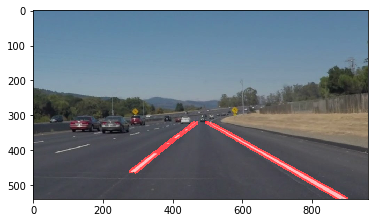

whiteCarLaneSwitch.jpg is currently being processed!


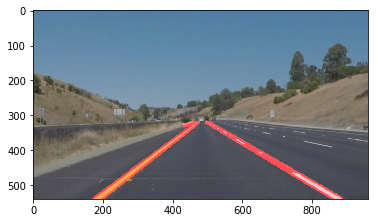

solidWhiteRight.jpg is currently being processed!


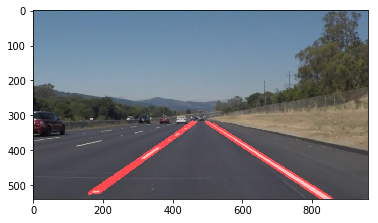

solidYellowCurve.jpg is currently being processed!


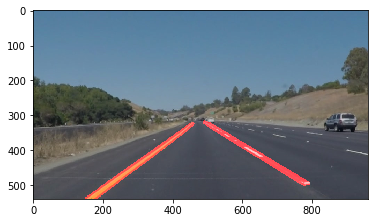

solidYellowCurve2.jpg is currently being processed!


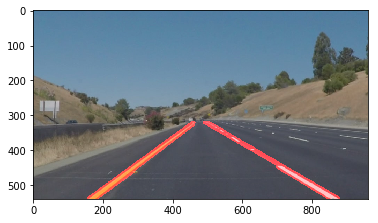

solidYellowLeft.jpg is currently being processed!


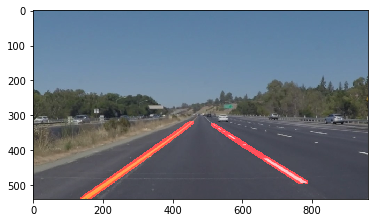

In [107]:
# Processing and reading all of the images above:
for images in os.listdir("test_images/"):
    image = mpimg.imread('test_images/' + images) 
    new_image = process_image_pipeline(image)
    plt.imshow(new_image)
    print(images, "is currently being processed!")
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [108]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [109]:
def process_image(image):

    # Copy: Makes a copy of the image
    image_copy = np.copy(image)
    
    # Color: Modifies the color of the image
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200
    
    # Theree color channel image
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    
    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
    image_copy[thresholds] = [0,0,0]
    
    # Gaussian: Applies a gaussian noise kernal to the image (used helper function provided)
    gaussian_blur_img = gaussian_blur(image, 5)

    # Canny: Sets up a canny transform
    canny_img = canny(gaussian_blur_img, 50, 130)
        
    # Size: Getting image size/shape
    y_size = image.shape[0]
    x_size = image.shape[1]

    # Region of interest: I defined a region of interest here (used helper function provided)
    vertices = np.array([[(50, y_size), (450, 320), (500, 320), (x_size, y_size)]], dtype = np.int32)
    region_of_interest_img = region_of_interest(canny_img, vertices)

    # Hough Lines: Sets up the parameters of the hough lines
    hough_lines_img = hough_lines(region_of_interest_img, 1 , np.pi/180, 20, 10, 200)
    
    # Weighted Image: Sets up the image to be processed
    result = weighted_img(hough_lines_img, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [110]:
white_output = 'test_videos_output/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4



100%|█████████▉| 221/222 [00:18<00:00, 11.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 8.38 s, sys: 224 ms, total: 8.61 s
Wall time: 20.5 s


In [111]:
white_output = 'test_videos_output/white.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4



100%|█████████▉| 221/222 [00:18<00:00, 11.82it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 8.33 s, sys: 231 ms, total: 8.56 s
Wall time: 20.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [113]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 92%|█████████▏| 625/682 [00:56<00:05, 10.84it/s]


100%|█████████▉| 681/682 [01:02<00:00, 10.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 25.9 s, sys: 766 ms, total: 26.7 s
Wall time: 1min 3s


In [114]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


# Project 1 - Finding lanes on the road report writeup

### 1. Describe your pipeline.
I named my function process_image_pipeline, and it consisted of numerous steps. I first started by converting my images to grayscale. Then, I used Gaussian blur, which applies a gaussian noise kernel to the image, and I used the helper function provided. After this, I set up a canny transform for my image to make sure the edges are detected properly. I assigned the image dimensions with an x and y variable. Then I defined some vertices with various numbers. This was the region of interest which is the region that was supposed to be defined by my vertices. Then I set up the weighted image to be processed.
To draw a single line on the left and right lanes, I modified the draw_lines() function by making changes to the slope. The slope is what will be used to draw the left and right sides of the line. The left lane of the road is negative, and the right lane of the road is positive. I first started by defining a list to put all of my values in for the left lanes and the right lanes. If the value for the slope is negative then all of them are appended to the “leftLane_list” list. And if the values are positive they are appended to the “rightLane_list” list. After this, I defined the image shape to be my max value, and a value of 400 to be my min value. Then I found my x1, y1, y2, and x2 values and did cv2.line(img, (x1, y1), (x2, y2), color, thickness) filling in the corresponding values for each.

### 2. Identify potential shortcomings with your current pipeline 
One potential shortcoming would be what would happen when my solidWhiteCurve.jpg image wasn't detected properly. It was the only one out of all my images to behave this way. 


This would probably be because I set my hough parameters incorrectly. Another shortcoming could be that this program won’t work well with curved lines on roads when turning.

### 3. Suggest possible improvements to your pipeline 
A possible improvement would be to modify my parameters so all of my images are 100% accurate. As of right now some of my images are lacking in proper line detection, but it is a satisfactory amount. Another potential improvement could be to make my code more advanced so that it will be able to detect lights at night under a brightly lit road. 


# Credit/Attribution

# CREDIT: UDACITY Quizzes - Used the code from Lesson 4 quizzes as refrence
# CREDIT: Referenced this githib to get an idea of what the paramters should look like: https://codynicholson.github.io/Finding_Lane_Lines_Project/
# CREDIT: Color Selection Code Example
# CREDIT: Referenced this blog post to learn more about draw_lines() function: https://medium.com/@c.ramprasad273/self-driving-car-nanodegree-udacity-project-1-finding-lane-lines-on-the-road-6b3c208aeada

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [115]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:48<00:00,  5.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 19.3 s, sys: 537 ms, total: 19.9 s
Wall time: 51.6 s


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

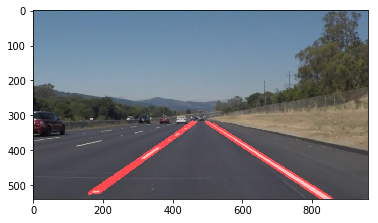

In [105]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')
process_image_pipeline(img)

In [1]:
!zip ../* mydata.zip

	zip warning: name not matched: mydata.zip

zip error: Nothing to do! (../CarND-LaneLines-P1.zip)
